In [1]:
# Needed for functions
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import time

# Import Qiskit Classes
from qiskit import *
from qiskit import IBMQ
from qiskit import transpile
from qiskit.providers.aer import AerSimulator, QasmSimulator, noise
from qiskit.providers.aer.extensions import *
from qiskit import quantum_info as qi
from qiskit.test.mock import FakeMontreal, FakeToronto, FakeSydney
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
import qiskit.ignis.mitigation.measurement as mc

# Import Visualization Tools
from qiskit.tools.visualization import plot_histogram as plth
from qiskit.visualization import plot_state_city, plot_state_hinton
from qiskit.tools.monitor import job_monitor
from qiskit.tools.jupyter import *


In [2]:
IBMQ.load_account()
provider = IBMQ.get_provider('ibm-q')


In [3]:
fake_montreal = FakeMontreal()
qcomp_sim_M = AerSimulator.from_backend(fake_montreal)
fake_montreal

<FakeMontreal('fake_montreal') from None()>

In [4]:
fake_toronto = FakeToronto()
qcomp_sim_T = AerSimulator.from_backend(fake_toronto)
fake_toronto

<FakeToronto('fake_toronto') from None()>

In [5]:
fake_sydney = FakeSydney()
qcomp_sim_S = AerSimulator.from_backend(fake_sydney)
fake_sydney

<FakeSydney('fake_sydney') from None()>

In [6]:
# Parametros libres globales
p_amp = 0.05
p_phs = 0.05
p_dprz = 0.05
shots = 8192

# Funcion para construir el circuito de codificación
def cod(creg = True):
    """
    Función que construye los pasos para realizar una codificación de 6
    qubits sobre un grafo conocido en la literatura como "Red Mariposa"
    usando un circuito construido mediante la teoría de QLNC.
    
    PARAMETROS:
        creg: Variable de tipo Booleano, para añadir o no un registro clásico.
        
    SALIDAS:
        qc: Circuito de la codificación.
    """
    qr = QuantumRegister(6, 'q')
    if creg:
        cr = ClassicalRegister(4, 'c')
        qc = QuantumCircuit(qr, cr)
    else:
        qc = QuantumCircuit(qr)

    qc.h([0, 1, 2, 3, 4, 5])

    qc.barrier()

    qc.cz([0, 1, 2], [3, 4, 5])
    qc.cz([0, 3], [1, 4])
    qc.cz([1, 4], [2, 5])

    qc.barrier()

    qc.h([1, 4])

    qc.barrier()

    qc.cx([1, 1, 4, 4], [0, 2, 3, 5])

    qc.barrier()

    qc.h([2, 5])

    return qc

# Función para ruido de Amplitud Damping
def amp_noise(p):
    """
    Funcion que sirve para crear un modelo ruidoso basado en Amplitud Damping
    y devolverlo al usuario, las operaciones sobre un solo qubit afectadas son
    rotación en z, raíz de X, rotación en 3 grados y el operador X, mientras
    que las operaciones sobre 2 qubits afectadas son las puertas X y Z controladas.
    
    PARAMETROS:
        p: Probabilidad de aplicar el efecto del ruido sobre el estado.
        
    SALIDAS:
        noisy_model_dprz: Modelo de ruido completo.
    """
    noise_amp_1 = noise.amplitude_damping_error(p)
    noise_amp_2 = noise_amp_1.tensor(noise_amp_1)
    # Modelo Ruidoso de Amplitud Damping
    noisy_model_amp = noise.NoiseModel()
    noisy_model_amp.add_all_qubit_quantum_error(noise_amp_1,
                                                ['rz', 'sx', 'x', 'u3'])
    noisy_model_amp.add_all_qubit_quantum_error(noise_amp_2,
                                                ['cx', 'cz'])
    return noisy_model_amp

# Función para ruido de Depolarizing
def phs_noise(p):
    """
    Crea un modelo ruidoso basado en Phase Damping y devolverlo al usuario,
    las operaciones sobre un solo qubit afectadas son rotación en z, raíz
    de X, rotación en 3 grados y el operador X, mientras que las operaciones
    sobre 2 qubits afectadas son las puertas X y Z controladas.
    
    PARAMETROS:
        p: Probabilidad de aplicar el efecto del ruido sobre el estado.
        
    SALIDAS:
        noisy_model_dprz: Modelo de ruido completo.
    """
    noise_phs_1 = noise.phase_damping_error(p)
    noise_phs_2 = noise_phs_1.tensor(noise_phs_1)
    # Modelo Ruidoso de Phase Damping
    noisy_model_phs = noise.NoiseModel()
    noisy_model_phs.add_all_qubit_quantum_error(noise_phs_1,
                                                ['rz', 'sx', 'x', 'u3'])
    noisy_model_phs.add_all_qubit_quantum_error(noise_phs_2,
                                                ['cx', 'cz'])
    return noisy_model_phs

# Función para ruido de Depolarizing
def dprz_noise(p):
    """
    Crea un modelo ruidoso basado en Depolarizing y devolverlo al usuario,
    las operaciones sobre un solo qubit afectadas son rotación en z, raíz
    de X, rotación en 3 grados y el operador X, mientras que las operaciones
    sobre 2 qubits afectadas son las puertas X y Z controladas.
    
    PARAMETROS:
        p: Probabilidad de aplicar el efecto del ruido sobre el estado.
        
    SALIDAS:
        noisy_model_dprz: Modelo de ruido completo.
    """
    noise_dprz_1 = noise.depolarizing_error(p, 1)
    noise_dprz_2 = noise.depolarizing_error(p, 2)
    # Modelo Ruidoso de Depolarizing
    noisy_model_dprz = noise.NoiseModel()
    noisy_model_dprz.add_all_qubit_quantum_error(noise_dprz_1,
                                                 ['rz', 'sx', 'x', 'u3'])
    noisy_model_dprz.add_all_qubit_quantum_error(noise_dprz_2,
                                                 ['cx', 'cz'])
    return noisy_model_dprz

#Función para calcular la fidelidad
def fid(qc, qc_noise, noise_model, shots):
    """
    Calcular la fidelidad cuántica entre 2 circuitos, uno ideal y otro con
    ruido. Como el simulador de estados incluido en QISKit realiza n cantidad
    de corridas, es necesario calcular la fidelidad individual de cada una y
    después promediar el resultado para luego devolverlo al usuario.
    
    PARAMETROS:
        qc: Circuito sin ruido.
        qc_noise: Circuito con ruido.
        noise_model: Modelo del ruido.
        shots: Número de simulaciones.
    SALIDAS:
        f/j: Promedio de las fidelidades calculadas en cada corrida.
    """
    
    f = 0
    j = 0
    
    sv_qc = qc.copy()
    sv_qc.snapshot_statevector('final')
    sv = execute(sv_qc, QasmSimulator()).result().data(0)['snapshots']['statevector']['final'][0]

    #Circuitos simulados con el ruido clasico
    sv_qc_noise = qc_noise.copy()
    sv_qc_noise.snapshot_statevector('final')
    sv_noise = execute(sv_qc_noise, QasmSimulator(), shots=shots, noise_model=noise_model,
                       basis_gates=noise_model.basis_gates
                      ).result().data(0)['snapshots']['statevector']['final']
    for i in range (0, len(sv_noise)):
        if np.round(abs(sum([n ** 2 for n in sv_noise[i]])),4)==1.0000:
            j += 1
            f += qi.state_fidelity(sv, sv_noise[i])
            
    
    return f/j

#Función para calcular la matriz densidad usando tomografía
def tomo(qc, backend, qubits=[], cal_id = [], tomo_id = [], trans=True):
    """
    Calcular la matriz densidad de un circuito cuántico a partir de
    los resultados experimentales en forma de probabilidades, usando
    el método de tomografía cuántica con la subrutina de mitigación
    de errores en la medida mediante la calibración de un filtro
    construido a partir de los resultados en el error por cada posible
    combinación del registro cuántico.
    
    PARAMETROS:
        qc: Circuito cuántico.
        backend: Backend del dispositivo que se esté utilizando.
        qubits: Lista con los qubits relacionados a la medida
        cal_id: Lista con los marcadores en el backend de los circuitos
            para calibración.
        tomo_id: Lista con los marcadores en el backend de los circuitos
            para calcular la tomografía.
        transpile: Variable de tipo booleana para determinar si hay o no
            que transpilar el circuito. Especialmente útil para simular
            ruidos.
        noise: Lista con los modelos de ruido a aplicar durante la tomo-
            grafía.
    SALIDAS:
        P: 
            Matriz densidad obtenida sin filtrar el ruido.
        job_tomo.result().time_taken/60: 
            Tiempo de ejecución de los circuitos para la tomografía
            dentro del backend.
        P_mit: 
            Matriz densidad obtenida sin filtrar el ruido.
        (job_cal.result().time_taken+job_tomo.result().time_taken)/60: 
            Tiempo de ejecución de los circuitos para  la tomografía
            y calibración del filtro dentro del backend.
    """
        
    # Generate Circuits and Fitter for Calibration tomography.
    if trans:
        tqc_tomo = transpile(qc, backend)
    else:
        tqc_tomo = qc.copy()

    if len(qubits)==0:
        qst_tqc = state_tomography_circuits(tqc_tomo,
                                            tqc_tomo.qubits)
        meas_cal, state_labels = mc.complete_meas_cal(tqc_tomo.qubits)

    else:
        qst_tqc = state_tomography_circuits(tqc_tomo,
                                            qubits)
        meas_cal, state_labels = mc.complete_meas_cal(qubits)

    
    # Execute Job callibrated and not
    if len(cal_id)==0:
        if len(meas_cal)<100:
            job_cal = qiskit.execute(meas_cal, backend=backend, shots=shots)
        else:
            i=100
            job_cal = qiskit.execute(meas_cal[i-100:i], backend=backend, shots=shots)
            while True:
                i+=100
                if(i > len(meas_cal)):
                    print(i)
                    job = qiskit.execute(meas_cal[i-100:len(qst_tqc)],
                                         backend=backend,
                                         shots=shots).result()
                    
                    job_cal.result().results += job.results
                    job_cal.result().time_taken += job.time_taken
                    
                    break
                job = qiskit.execute(meas_cal[i-100:i],
                                     backend=backend,
                                     shots=shots).result()
                
                job_cal.result().results += job.results
                job_cal.result().time_taken += job.time_taken
                    
    else:
        job_cal = backend.retrieve_job(cal_id.pop(0))
        while len(cal_id)!=0:
            job = backend.retrieve_job(cal_id.pop(0)).result()
            
            job_cal.result().results += job.results
            job_cal.result().results += job.time_taken
            
            
    if len(tomo_id)==0:
        if len(qst_tqc)<100:
            job_tomo = qiskit.execute(qst_tqc, backend=backend, shots=shots)
        else:
            i=100
            job_tomo = qiskit.execute(qst_tqc[i-100:i], backend=backend, shots=shots)
            while True:
                i+=100
                if(i > len(qst_tqc)):
                    job = qiskit.execute(qst_tqc[i-100:len(qst_tqc)],
                                                   backend=backend,
                                                   shots=shots).result()
                    
                    job_tomo.result().results += job.results
                    job_tomo.result().time_taken += job.time_taken
                    
                    break
                job = qiskit.execute(qst_tqc[i-100:i],
                                               backend=backend,
                                               shots=shots).result()
                
                job_tomo.result().results += job.results
                job_tomo.result().time_taken += job.time_taken
                    
    else:
        job_tomo = backend.retrieve_job(tomo_id.pop(0))
        while len(tomo_id)!=0:
            job = backend.retrieve_job(tomo_id.pop(0)).result()

            job_tomo.result().results += job.results
            job_tomo.result().time_taken += job.time_taken
            
    meas_fitter = mc.CompleteMeasFitter(job_cal.result(), state_labels)
    tomo_tqc = StateTomographyFitter(job_tomo.result(), qst_tqc)

    # no correction
    P = tomo_tqc.fit(method='lstsq')

    # corrected data
    corr_tomo_tqc_res = meas_fitter.filter.apply(job_tomo.result(), method='least_squares')
    tomo_tqc_mit = StateTomographyFitter(corr_tomo_tqc_res, qst_tqc)
    P_mit = tomo_tqc_mit.fit(method='lstsq')
    
    return [P, job_tomo.result().time_taken/60, P_mit, (job_cal.result().time_taken+job_tomo.result().time_taken)/60]


Profundidad del Circuito:  8


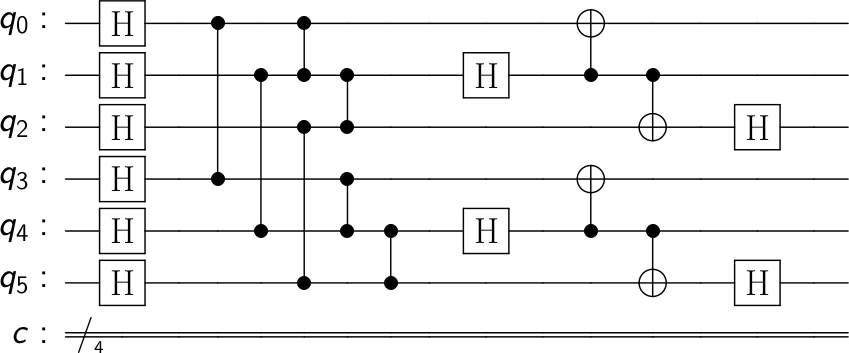

None

In [7]:
qc = cod()
display(qc.draw(output = 'latex', plot_barriers=False),
        print("Profundidad del Circuito: ", qc.depth()))


In [ ]:
Statevector&([ 2.50000000e-01+0.j,  3.52289810e-18+0.j,\\ &  2.50000000e-01+0.j,
              3.52289810e-18+0.j,\\ &  4.76210391e-18+0.j,  6.31580767e-35+0.j,\\
           &   4.76210391e-18+0.j,  6.31580767e-35+0.j,\\ &  4.76210391e-18+0.j,
              6.31580767e-35+0.j,\\ &  4.76210391e-18+0.j,  6.31580767e-35+0.j,\\
           &   2.50000000e-01+0.j,  3.52289810e-18+0.j,\\ &  2.50000000e-01+0.j,
              3.52289810e-18+0.j,\\ &  2.50000000e-01+0.j,  3.52289810e-18+0.j,\\
           &  -2.50000000e-01+0.j, -3.52289810e-18+0.j,\\ &  4.76210391e-18+0.j,
              6.31580767e-35+0.j,\\ & -4.76210391e-18+0.j, -6.31580767e-35+0.j,\\
           &   4.76210391e-18+0.j,  6.31580767e-35+0.j,\\ & -4.76210391e-18+0.j,
             -6.31580767e-35+0.j,\\ &  2.50000000e-01+0.j,  3.52289810e-18+0.j,\\
           &  -2.50000000e-01+0.j, -3.52289810e-18+0.j,\\ &  3.52289810e-18+0.j,
              2.50000000e-01+0.j,\\ &  3.52289810e-18+0.j,  2.50000000e-01+0.j,\\
           &   6.31580767e-35+0.j,  4.76210391e-18+0.j,\\ &  6.31580767e-35+0.j,
              4.76210391e-18+0.j,\\ &  6.31580767e-35+0.j,  4.76210391e-18+0.j,\\
           &   6.31580767e-35+0.j,  4.76210391e-18+0.j,\\ &  3.52289810e-18+0.j,
              2.50000000e-01+0.j,\\ &  3.52289810e-18+0.j,  2.50000000e-01+0.j,\\
           &   3.52289810e-18+0.j,  2.50000000e-01+0.j,\\ & -3.52289810e-18+0.j,
             -2.50000000e-01+0.j,\\ &  6.31580767e-35+0.j,  4.76210391e-18+0.j,\\
           &  -6.31580767e-35+0.j, -4.76210391e-18+0.j,\\ &  6.31580767e-35+0.j,
              4.76210391e-18+0.j,\\ & -6.31580767e-35+0.j, -4.76210391e-18+0.j,\\
           &   3.52289810e-18+0.j,  2.50000000e-01+0.j,\\ & -3.52289810e-18+0.j,
             -2.50000000e-01+0.j],\\
           & dims=(2, 2, 2, 2, 2, 2))

Statevector([ 2.50000000e-01+0.j,  3.52289810e-18+0.j,  2.50000000e-01+0.j,
              3.52289810e-18+0.j,  4.76210391e-18+0.j,  6.31580767e-35+0.j,
              4.76210391e-18+0.j,  6.31580767e-35+0.j,  4.76210391e-18+0.j,
              6.31580767e-35+0.j,  4.76210391e-18+0.j,  6.31580767e-35+0.j,
              2.50000000e-01+0.j,  3.52289810e-18+0.j,  2.50000000e-01+0.j,
              3.52289810e-18+0.j,  2.50000000e-01+0.j,  3.52289810e-18+0.j,
             -2.50000000e-01+0.j, -3.52289810e-18+0.j,  4.76210391e-18+0.j,
              6.31580767e-35+0.j, -4.76210391e-18+0.j, -6.31580767e-35+0.j,
              4.76210391e-18+0.j,  6.31580767e-35+0.j, -4.76210391e-18+0.j,
             -6.31580767e-35+0.j,  2.50000000e-01+0.j,  3.52289810e-18+0.j,
             -2.50000000e-01+0.j, -3.52289810e-18+0.j,  3.52289810e-18+0.j,
              2.50000000e-01+0.j,  3.52289810e-18+0.j,  2.50000000e-01+0.j,
              6.31580767e-35+0.j,  4.76210391e-18+0.j,  6.31580767e-35+0.j,
            

None

C:\ProgramData\Anaconda3\envs\MyEnv\lib\site-packages\qiskit\visualization\state_visualization.py:705: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, _ = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)


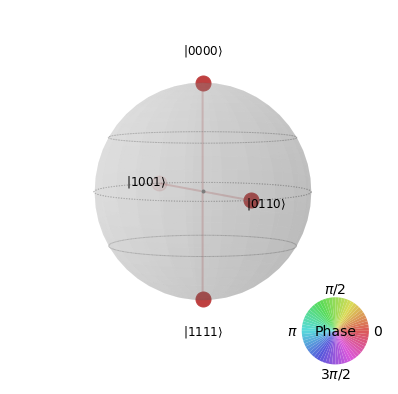

In [8]:
svs = BasicAer.get_backend('statevector_simulator')
qc_svs = execute(qc, svs).result()
qc_P  = qi.partial_trace(qi.DensityMatrix(qc_svs.get_statevector(qc)), [1, 4])
qc_sv = qi.Statevector.from_instruction(qc)
display(print(qc_sv),
        #psi.draw(output='qsphere'),
        qc_P.draw(output='qsphere'),
        # plot_state_city(Ro_psi),
        #plot_state_hinton(psi)
       )


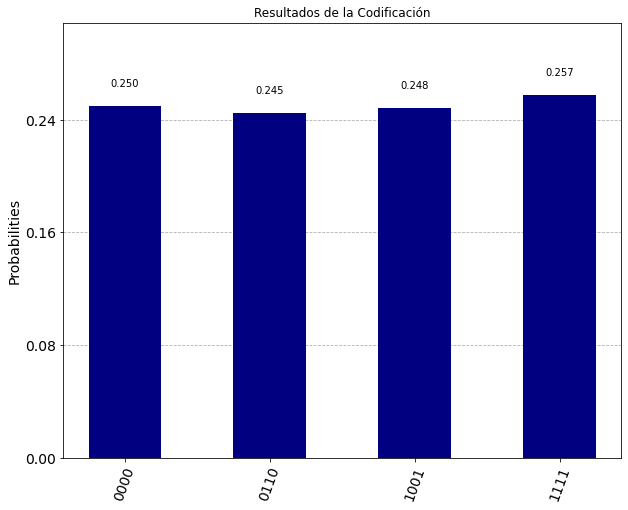

In [9]:
qc_meas = qc.copy()
qc_meas.measure([0, 2, 3, 5], [0, 1, 2, 3])
sim = Aer.get_backend('qasm_simulator')
results = execute(qc_meas, backend = sim, shots = shots).result()
counts = results.get_counts()
plth(counts,
     title='Resultados de la Codificación',
     color=[
            'navy'
           ],
     figsize=(10, 8)
)

In [29]:
print(counts)
for i in counts:
    print(i, ': ',counts[i], '/',round(counts[i]/shots, 5))

{'0110': 2006, '1111': 2109, '0000': 2045, '1001': 2032}
0110 :  2006 / 0.24487
1111 :  2109 / 0.25745
0000 :  2045 / 0.24963
1001 :  2032 / 0.24805


In [11]:
# Transpile the circuit for the noisy sistem's basis gates
tqc_sim_m = transpile(cod(False), qcomp_sim_M,)
tqc_sim_m_sv = qi.Statevector.from_instruction(tqc_sim_m)
tqc_sim_m_meas = transpile(qc_meas, qcomp_sim_M)

tqc_sim_t = transpile(cod(False), qcomp_sim_T)
tqc_sim_t_sv = qi.Statevector.from_instruction(tqc_sim_t)
tqc_sim_t_meas = transpile(qc_meas, qcomp_sim_T)

tqc_sim_s = transpile(cod(False), qcomp_sim_S)
tqc_sim_s_sv = qi.Statevector.from_instruction(tqc_sim_s)
tqc_sim_s_meas = transpile(qc_meas, qcomp_sim_S)




Profundidad del Circuito usando el modelo de prueba:
  53


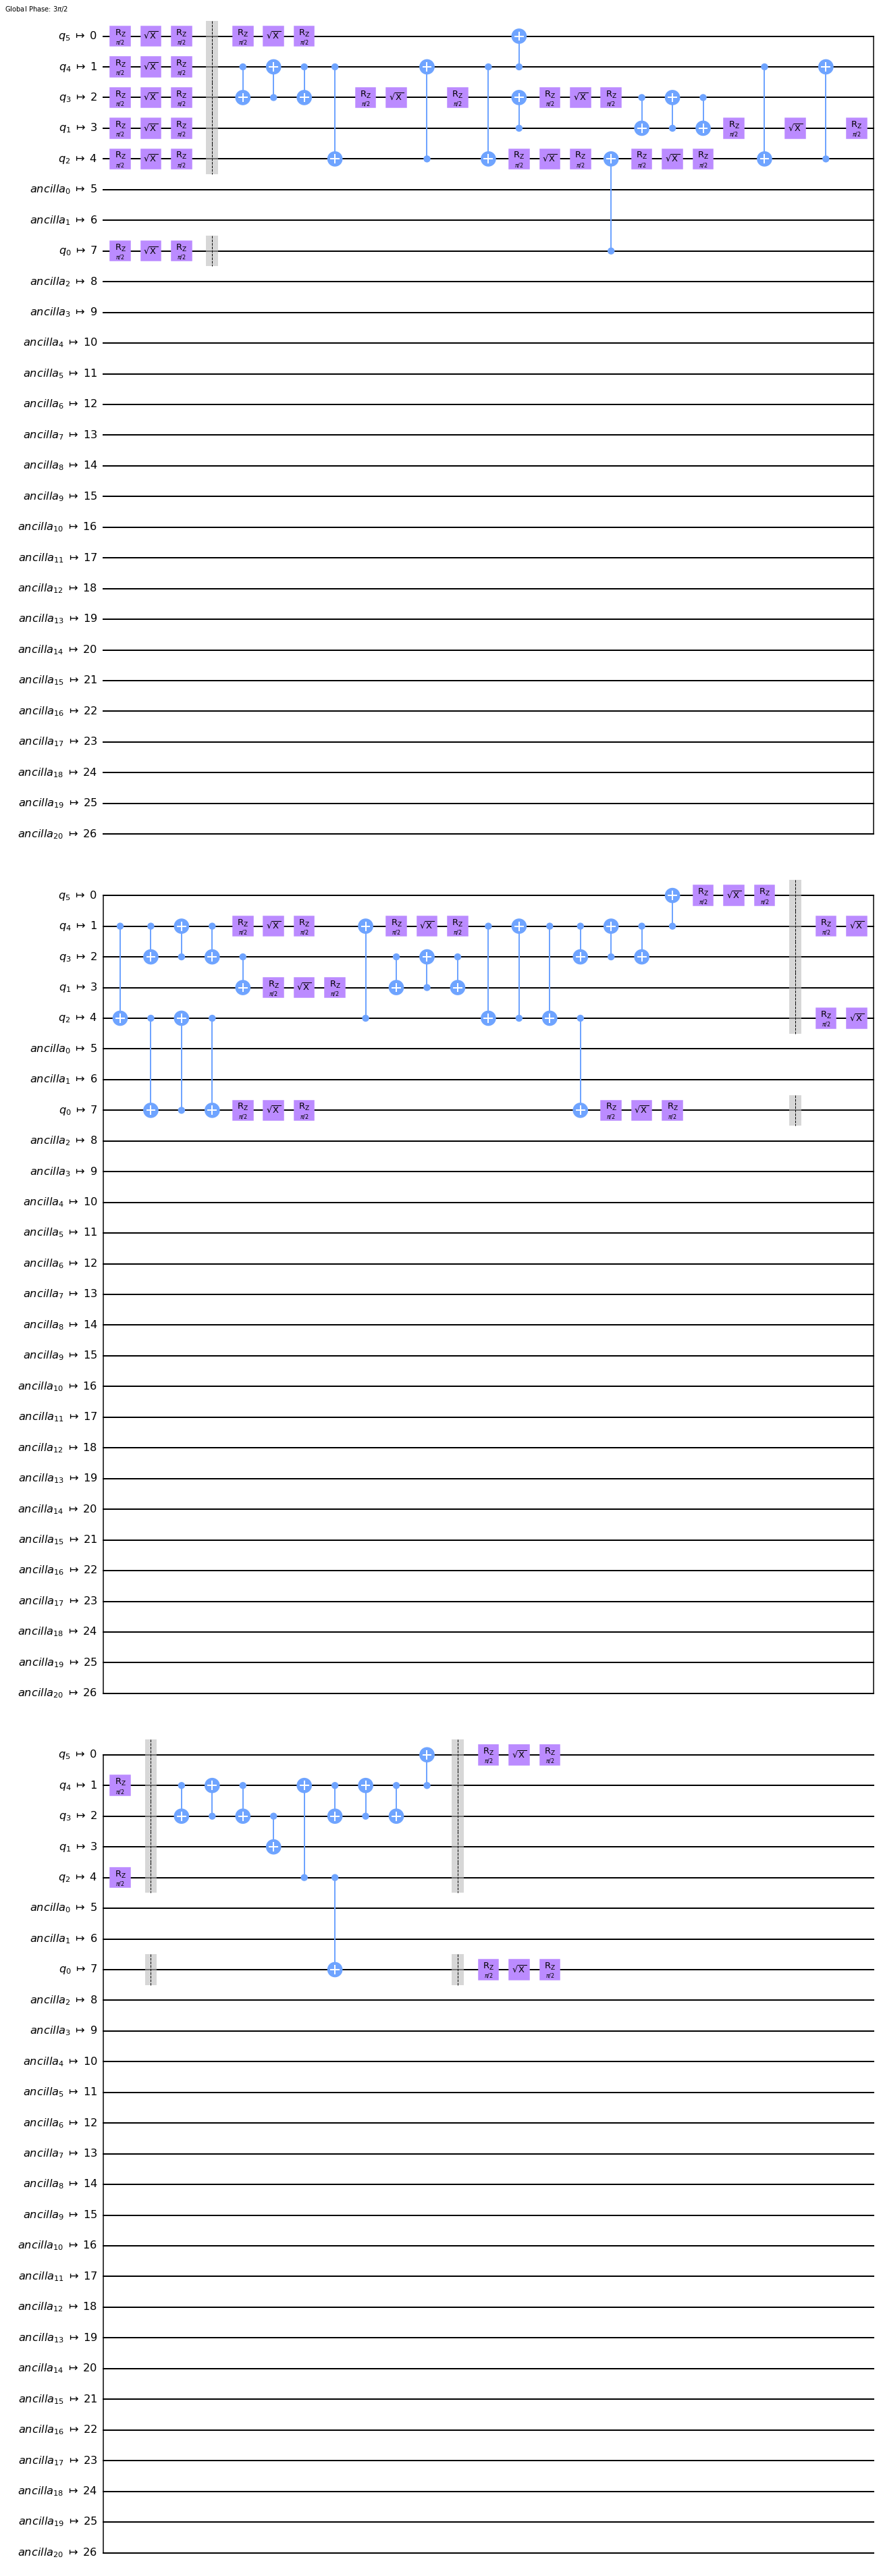

None

In [12]:
mpl.rcParams["figure.figsize"] = mpl.rcParamsDefault["figure.figsize"]

display(tqc_sim_m.draw('mpl'),
#        print("\n\nVector de estado del Circuito usando el modelo de prueba:\n ", tqc_sim_m_sv),
        print("\n\nProfundidad del Circuito usando el modelo de prueba:\n ", tqc_sim_m.depth()))




Profundidad del Circuito usando el modelo de prueba:
  47


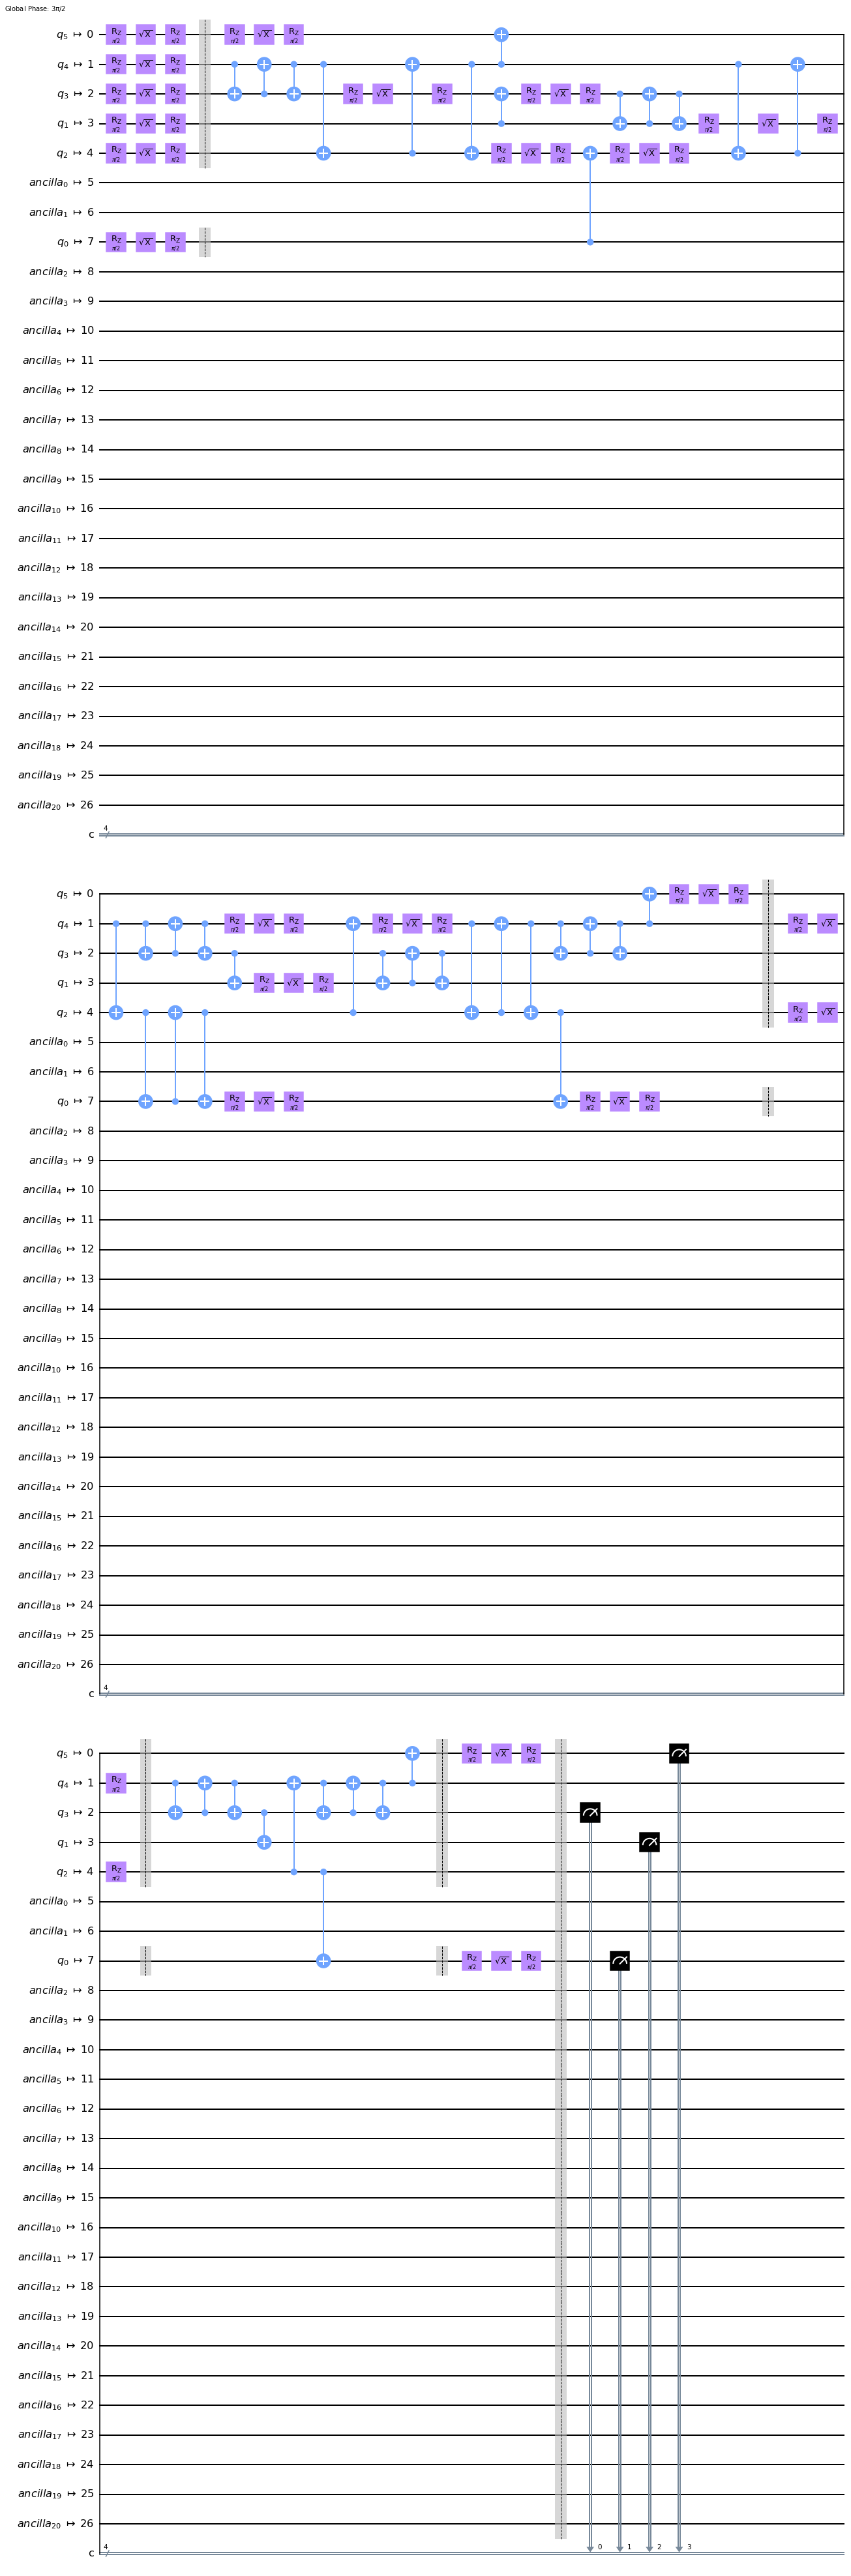

None

In [13]:
mpl.rcParams["figure.figsize"] = mpl.rcParamsDefault["figure.figsize"]

display(tqc_sim_t_meas.draw('mpl'),
#        print("\n\nVector de estado del Circuito usando el modelo de prueba:\n ", tqc_sim_t_sv),
        print("\n\nProfundidad del Circuito usando el modelo de prueba:\n ", tqc_sim_t.depth()))




Profundidad del Circuito usando el modelo de prueba:
  50


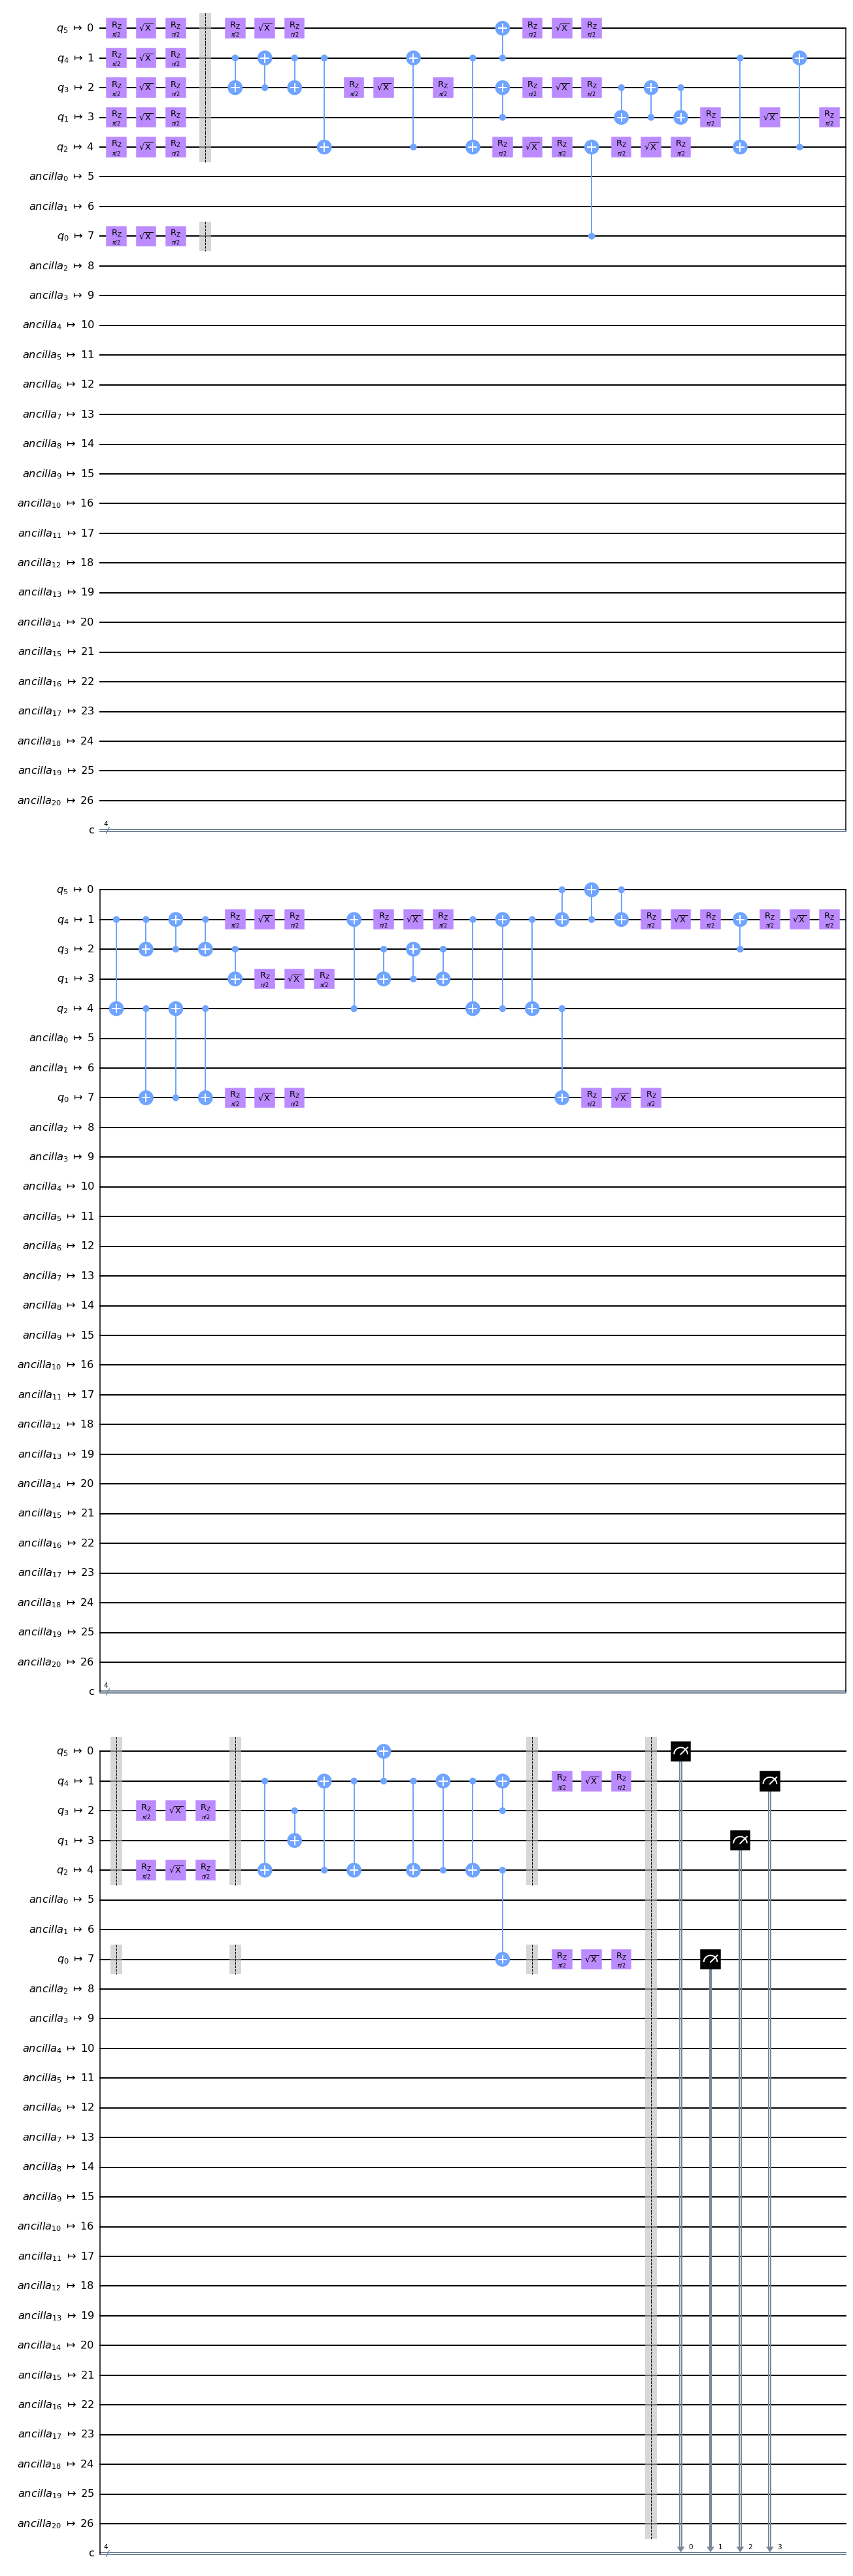

None

In [14]:
mpl.rcParams["figure.figsize"] = mpl.rcParamsDefault["figure.figsize"]

display(tqc_sim_s_meas.draw('mpl'),
#        print("\n\nVector de estado del Circuito usando el modelo de prueba:\n ", tqc_sim_s_sv),
        print("\n\nProfundidad del Circuito usando el modelo de prueba:\n ", tqc_sim_s.depth()))


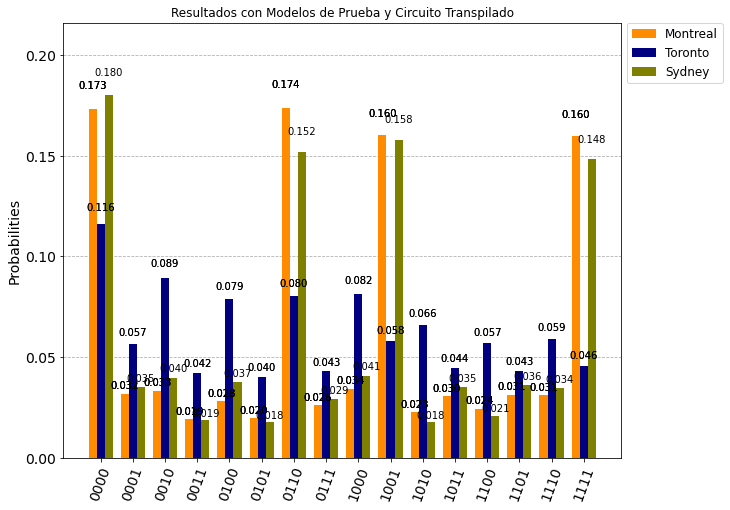

In [12]:
# Execute noisy simulation on dummys and get counts
result_noise_sim_m = qcomp_sim_M.run(tqc_sim_m_meas, shots=shots).result()
result_noise_sim_t = qcomp_sim_T.run(tqc_sim_t_meas, shots=shots).result()
result_noise_sim_s = qcomp_sim_S.run(tqc_sim_s_meas, shots=shots).result()

counts_noise_sim_m = result_noise_sim_m.get_counts(tqc_sim_m_meas)
counts_noise_sim_t = result_noise_sim_t.get_counts(tqc_sim_t_meas)
counts_noise_sim_s = result_noise_sim_s.get_counts(tqc_sim_s_meas)

plth(
    [counts_noise_sim_m,
     counts_noise_sim_t,
     counts_noise_sim_s
    ],
    legend=['Montreal',
            'Toronto',
            'Sydney'
           ],
    title='Resultados con Modelos de Prueba y Circuito Transpilado',
    color=['darkorange',
           'navy',
           'olive'
          ],
    figsize=(10, 8)
)

In [20]:
print('Cuentas de la codificación con "Montreal": \n', counts_noise_sim_m)
for i in counts_noise_sim_m:
    print(i, ': ',counts_noise_sim_m[i], '/',counts_noise_sim_m[i]/shots)
print('\nCuentas de la codificación con "Toronto": \n', counts_noise_sim_t)
for i in counts_noise_sim_t:
    print(i, ': ',counts_noise_sim_t[i], '/',counts_noise_sim_t[i]/shots)
print('\nCuentas de la codificación con "Sydney": \n', counts_noise_sim_s)
for i in counts_noise_sim_s:
    print(i, ': ',counts_noise_sim_s[i], '/',counts_noise_sim_s[i]/shots)


Cuentas de la codificación con "Montreal": 
 {'1111': 1311, '0110': 1425, '0111': 214, '1001': 1313, '0101': 163, '0010': 272, '0000': 1421, '0100': 230, '1011': 249, '0001': 261, '1100': 200, '0011': 159, '1000': 278, '1110': 254, '1101': 256, '1010': 186}
1111 :  1311 / 0.1600341796875
0110 :  1425 / 0.1739501953125
0111 :  214 / 0.026123046875
1001 :  1313 / 0.1602783203125
0101 :  163 / 0.0198974609375
0010 :  272 / 0.033203125
0000 :  1421 / 0.1734619140625
0100 :  230 / 0.028076171875
1011 :  249 / 0.0303955078125
0001 :  261 / 0.0318603515625
1100 :  200 / 0.0244140625
0011 :  159 / 0.0194091796875
1000 :  278 / 0.033935546875
1110 :  254 / 0.031005859375
1101 :  256 / 0.03125
1010 :  186 / 0.022705078125

Cuentas de la codificación con "Toronto": 
 {'1110': 483, '0101': 328, '1001': 473, '1100': 467, '0011': 344, '0010': 733, '1000': 668, '0100': 644, '0000': 950, '0111': 351, '0110': 657, '1111': 375, '1011': 364, '1010': 539, '1101': 352, '0001': 464}
1110 :  483 / 0.05895996

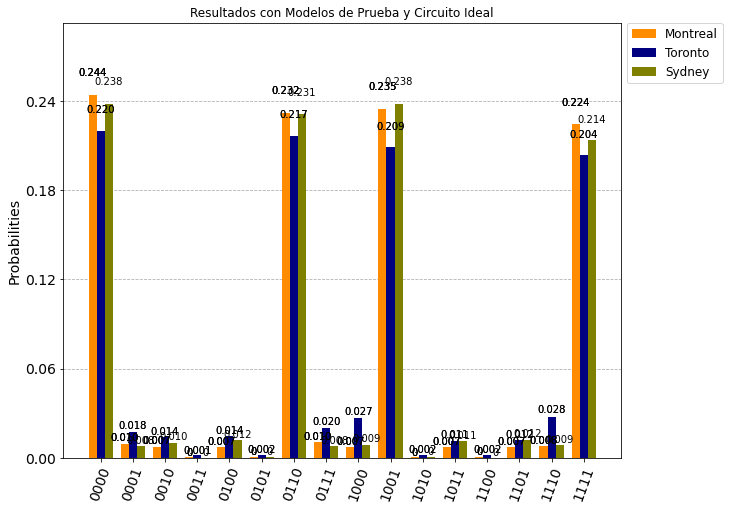

In [14]:
# Execute noisy simulation on dummys and get counts
result_noise_m = qcomp_sim_M.run(qc_meas, shots=shots).result()
result_noise_t = qcomp_sim_T.run(qc_meas, shots=shots).result()
result_noise_s = qcomp_sim_S.run(qc_meas, shots=shots).result()

counts_noise_m = result_noise_m.get_counts(qc_meas)
counts_noise_t = result_noise_t.get_counts(qc_meas)
counts_noise_s = result_noise_s.get_counts(qc_meas)

plth(
    [counts_noise_m,
     counts_noise_t,
     counts_noise_s
    ],
    legend=['Montreal',
            'Toronto',
            'Sydney'
           ],
    title='Resultados con Modelos de Prueba y Circuito Ideal',
    color=['darkorange',
           'navy',
           'olive'
          ],
    figsize=(10, 8)
)

In [40]:
print('Cuentas de la codificación simulada con "Montreal": \n', counts_noise_m)
for i in range(len(counts_noise_m)):
    print('{0:04b}'.format(i), ': ',counts_noise_m['{0:04b}'.format(i)], '/',round(counts_noise_m['{0:04b}'.format(i)]/shots, 5))
print('\nCuentas de la codificación simulada con "Toronto": \n', counts_noise_t)
for i in range(len(counts_noise_t)):
    print('{0:04b}'.format(i), ': ',counts_noise_t['{0:04b}'.format(i)], '/',round(counts_noise_t['{0:04b}'.format(i)]/shots, 5))
print('\nCuentas de la codificación simulada con "Sydney": \n', counts_noise_s)
for i in range(len(counts_noise_t)):
    if '{0:04b}'.format(i) in counts_noise_s.keys():
        print('{0:04b}'.format(i), ': ',counts_noise_s['{0:04b}'.format(i)], '/',round(counts_noise_s['{0:04b}'.format(i)]/shots, 5))


Cuentas de la codificación simulada con "Montreal": 
 {'0110': 1901, '1111': 1838, '1001': 1925, '1000': 57, '0000': 1999, '1110': 62, '0111': 85, '1011': 57, '0001': 78, '0010': 61, '1100': 4, '1101': 59, '0100': 58, '0101': 5, '1010': 1, '0011': 2}
0000 :  1999 / 0.24402
0001 :  78 / 0.00952
0010 :  61 / 0.00745
0011 :  2 / 0.00024
0100 :  58 / 0.00708
0101 :  5 / 0.00061
0110 :  1901 / 0.23206
0111 :  85 / 0.01038
1000 :  57 / 0.00696
1001 :  1925 / 0.23499
1010 :  1 / 0.00012
1011 :  57 / 0.00696
1100 :  4 / 0.00049
1101 :  59 / 0.0072
1110 :  62 / 0.00757
1111 :  1838 / 0.22437

Cuentas de la codificación simulada con "Toronto": 
 {'0111': 165, '1111': 1670, '0110': 1775, '1000': 218, '0000': 1803, '1110': 226, '1010': 14, '1001': 1715, '0001': 144, '1101': 97, '1011': 93, '0100': 117, '0010': 113, '0011': 12, '0101': 14, '1100': 16}
0000 :  1803 / 0.22009
0001 :  144 / 0.01758
0010 :  113 / 0.01379
0011 :  12 / 0.00146
0100 :  117 / 0.01428
0101 :  14 / 0.00171
0110 :  1775 / 0.2

In [42]:
t = time.time()

P_sim = tomo(qc=cod(False),
             backend=qcomp_sim_M,
             qubits=[0, 1, 2, 3, 4, 5],
             trans=False
            ) 

F_sim_m = qi.state_fidelity(P_sim[0], qc_sv)
F_sim_m_mit = qi.state_fidelity(P_sim[2], qc_sv)
print('Fidelidad en el Modelo de prueba de "Montreal" (s/ corrección): F = {:.5f}'.format(F_sim_m))
print('                                               (c/ corrección): F = {:.5f}'.format(F_sim_m_mit))
print('\n\nTiempo de ejecución [minutos] (s/ corrección): t = {:.5f}'.format(P_sim[1]))
print('                              (c/ corrección): t = {:.5f}'.format(P_sim[3]))
print('\n\nTiempo transcurrido [segundos] : t = {:.5f}'.format(time.time() - t))


Fidelidad en el Modelo de prueba de "Montreal" (s/ corrección): F = 0.50559
                                               (c/ corrección): F = 0.61823


Tiempo de ejecución [minutos] (s/ corrección): t = 2.36686
                              (c/ corrección): t = 2.57205


Tiempo transcurrido [segundos] : t = 481.41710


In [43]:
t = time.time()

P_sim = tomo(qc=cod(False),
             backend=qcomp_sim_T,
             qubits=[0, 1, 2, 3, 4, 5],
             trans=False
            ) 

F_sim_t = qi.state_fidelity(P_sim[0], qc_sv)
F_sim_t_mit = qi.state_fidelity(P_sim[2], qc_sv)
print('Fidelidad en el Modelo de prueba de "Toronto" (s/ corrección): F = {:.5f}'.format(F_sim_t))
print('                                              (c/ corrección): F = {:.5f}'.format(F_sim_t_mit))
print('\n\nTiempo de ejecución [minutos] (s/ corrección): t = {:.5f}'.format(P_sim[1]))
print('                              (c/ corrección): t = {:.5f}'.format(P_sim[3]))
print('\n\nTiempo transcurrido [segundos] : t = {:.5f}'.format(time.time() - t))


Fidelidad en el Modelo de prueba de "Toronto" (s/ corrección): F = 0.04769
                                              (c/ corrección): F = 0.05681


Tiempo de ejecución [minutos] (s/ corrección): t = 0.81688
                              (c/ corrección): t = 0.88558


Tiempo transcurrido [segundos] : t = 383.30405


In [44]:
t = time.time()

P_sim = tomo(qc=cod(False),
             backend=qcomp_sim_S,
             qubits=[0, 1, 2, 3, 4, 5],
             trans=False
            ) 

F_sim_s = qi.state_fidelity(P_sim[0], qc_sv)
F_sim_s_mit = qi.state_fidelity(P_sim[2], qc_sv)
print('Fidelidad en el Modelo de prueba de "Sydney" (s/ corrección): F = {:.5f}'.format(F_sim_s))
print('                                             (c/ corrección): F = {:.5f}'.format(F_sim_s_mit))
print('\n\nTiempo de ejecución [minutos] (s/ corrección): t = {:.5f}'.format(P_sim[1]))
print('                              (c/ corrección): t = {:.5f}'.format(P_sim[3]))
print('\n\nTiempo transcurrido [segundos] : t = {:.5f}'.format(time.time() - t))


Fidelidad en el Modelo de prueba de "Sydney" (s/ corrección): F = 0.46220
                                             (c/ corrección): F = 0.56923


Tiempo de ejecución [minutos] (s/ corrección): t = 2.27264
                              (c/ corrección): t = 2.48134


Tiempo transcurrido [segundos] : t = 472.23310


In [16]:
# RUIDOS

noisy_amp = amp_noise(p=p_amp)

noisy_phs = phs_noise(p=p_phs)

noisy_dprz = dprz_noise(p=p_dprz)

print(noisy_amp)
print(noisy_phs)
print(noisy_dprz)


NoiseModel:
  Basis gates: ['cx', 'cz', 'id', 'rz', 'sx', 'u3', 'x']
  Instructions with noise: ['x', 'u3', 'cz', 'cx', 'sx', 'rz']
  All-qubits errors: ['rz', 'sx', 'x', 'u3', 'cx', 'cz']
NoiseModel:
  Basis gates: ['cx', 'cz', 'id', 'rz', 'sx', 'u3', 'x']
  Instructions with noise: ['x', 'u3', 'cz', 'cx', 'sx', 'rz']
  All-qubits errors: ['rz', 'sx', 'x', 'u3', 'cx', 'cz']
NoiseModel:
  Basis gates: ['cx', 'cz', 'id', 'rz', 'sx', 'u3', 'x']
  Instructions with noise: ['x', 'u3', 'cz', 'cx', 'sx', 'rz']
  All-qubits errors: ['rz', 'sx', 'x', 'u3', 'cx', 'cz']


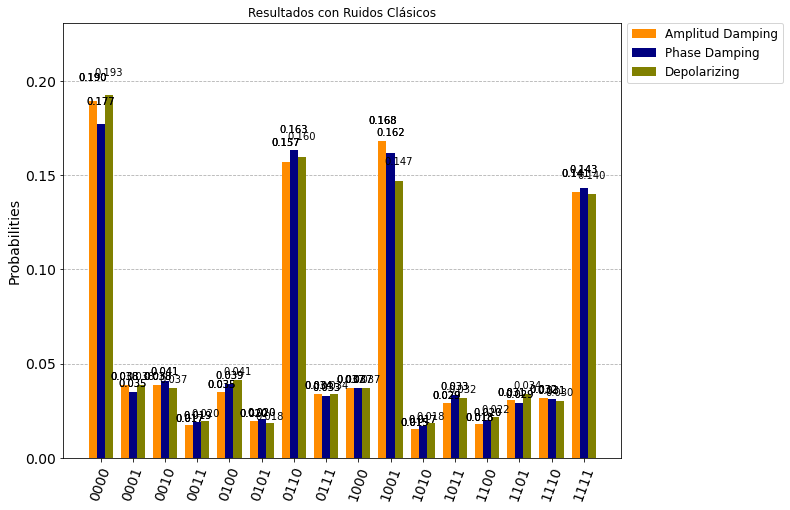

In [17]:
# Simular el Ruido de Amplitud Damping
sim_noise_amp = AerSimulator(noise_model=noisy_amp)
sim_noise_phs = AerSimulator(noise_model=noisy_phs)
sim_noise_dprz = AerSimulator(noise_model=noisy_dprz)

tqc_noise_amp = transpile(qc, sim_noise_amp)
tqc_noise_phs = transpile(qc, sim_noise_phs)
tqc_noise_dprz = transpile(qc, sim_noise_dprz)

tqc_noise_amp_meas = tqc_noise_amp.copy()
tqc_noise_amp_meas.measure([0, 2, 3, 5], [0, 1, 2, 3])
result_noise_amp = sim_noise_amp.run(tqc_noise_amp_meas, shots=shots).result()

tqc_noise_phs_meas = tqc_noise_phs.copy()
tqc_noise_phs_meas.measure([0, 2, 3, 5], [0, 1, 2, 3])
result_noise_phs = sim_noise_amp.run(tqc_noise_phs_meas, shots=shots).result()

tqc_noise_dprz_meas = tqc_noise_dprz.copy()
tqc_noise_dprz_meas.measure([0, 2, 3, 5], [0, 1, 2, 3])
result_noise_dprz = sim_noise_amp.run(tqc_noise_dprz_meas, shots=shots).result()

counts_noise_amp = result_noise_amp.get_counts(tqc_noise_amp_meas)
counts_noise_phs = result_noise_phs.get_counts(tqc_noise_phs_meas)
counts_noise_dprz = result_noise_dprz.get_counts(tqc_noise_dprz_meas)

plth(
    [counts_noise_amp,
     counts_noise_phs,
     counts_noise_dprz
    ],
    legend=['Amplitud Damping',
            'Phase Damping',
            'Depolarizing'
           ],
    title='Resultados con Ruidos Clásicos',
    color=['darkorange',
           'navy',
           'olive'
          ],
    figsize=(10, 8)
)

In [27]:
print('Cuentas de la codificación con Amp Dmp: \n', counts_noise_amp)
for i in counts_noise_amp:
    print(i, ': ',counts_noise_amp[i], '/',round(counts_noise_amp[i]/shots,5))
print('\nCuentas de la codificación con Phs Dmp: \n', counts_noise_phs)
for i in counts_noise_phs:
    print(i, ': ',counts_noise_phs[i], '/',round(counts_noise_phs[i]/shots,5))
print('\nCuentas de la codificación con Dprz: \n', counts_noise_dprz)
for i in counts_noise_dprz:
    print(i, ': ',counts_noise_dprz[i], '/',round(counts_noise_dprz[i]/shots,5))


Cuentas de la codificación con Amp Dmp: 
 {'1111': 1158, '0110': 1286, '0000': 1554, '1000': 303, '0111': 279, '0001': 315, '1001': 1378, '0010': 314, '1101': 250, '1110': 261, '0100': 284, '0101': 160, '1100': 145, '1011': 236, '1010': 126, '0011': 143}
1111 :  1158 / 0.14136
0110 :  1286 / 0.15698
0000 :  1554 / 0.1897
1000 :  303 / 0.03699
0111 :  279 / 0.03406
0001 :  315 / 0.03845
1001 :  1378 / 0.16821
0010 :  314 / 0.03833
1101 :  250 / 0.03052
1110 :  261 / 0.03186
0100 :  284 / 0.03467
0101 :  160 / 0.01953
1100 :  145 / 0.0177
1011 :  236 / 0.02881
1010 :  126 / 0.01538
0011 :  143 / 0.01746

Cuentas de la codificación con Phs Dmp: 
 {'1000': 304, '0000': 1453, '1010': 139, '1001': 1325, '0001': 286, '0111': 269, '1111': 1172, '1101': 239, '0110': 1337, '1110': 256, '0100': 319, '1100': 166, '0011': 153, '0010': 335, '1011': 272, '0101': 167}
1000 :  304 / 0.03711
0000 :  1453 / 0.17737
1010 :  139 / 0.01697
1001 :  1325 / 0.16174
0001 :  286 / 0.03491
0111 :  269 / 0.03284
1

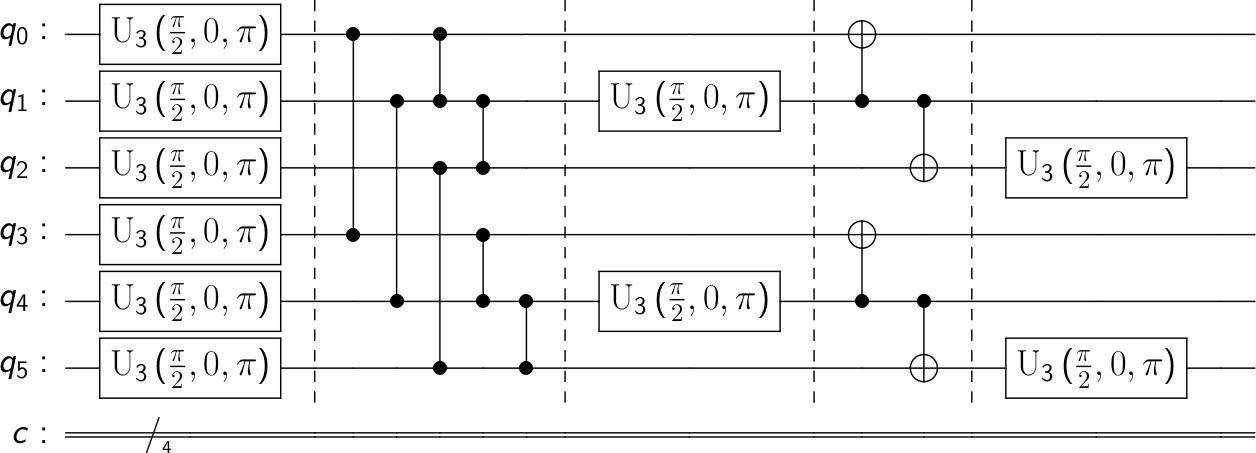

In [22]:
mpl.rcParams["figure.figsize"] = mpl.rcParamsDefault["figure.figsize"]
tqc_noise_amp.draw('latex')

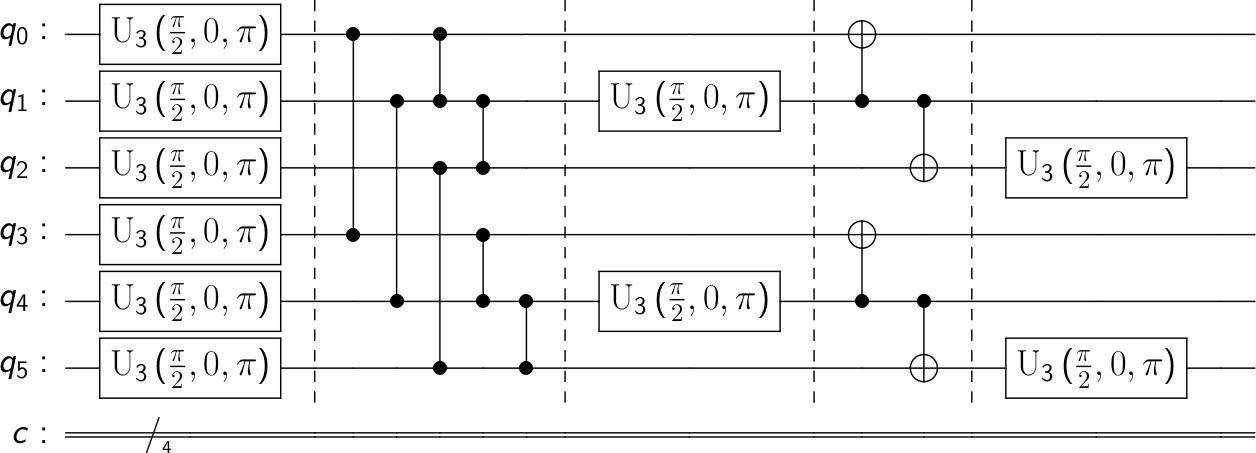

In [23]:
mpl.rcParams["figure.figsize"] = mpl.rcParamsDefault["figure.figsize"]
tqc_noise_phs.draw('latex')

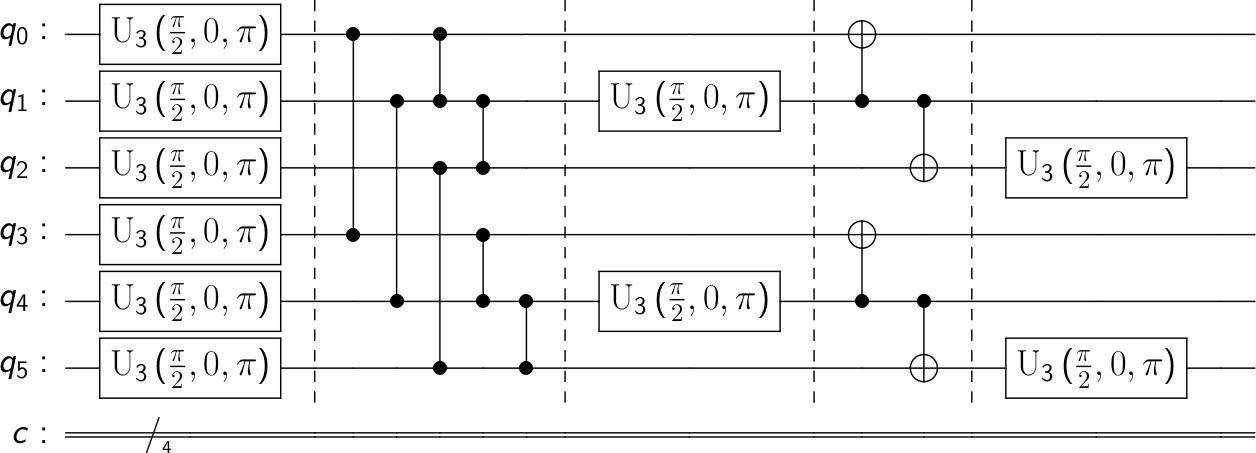

In [24]:
mpl.rcParams["figure.figsize"] = mpl.rcParamsDefault["figure.figsize"]
tqc_noise_dprz.draw('latex')

In [25]:
t = time.time()

P_sim = tomo(qc=cod(False),
             backend=sim_noise_amp,
             qubits=[0, 1, 2, 3, 4, 5],
            ) 

F_sim_m = qi.state_fidelity(P_sim[0], qc_sv)
F_sim_m_mit = qi.state_fidelity(P_sim[2], qc_sv)
print('Fidelidad en el Modelo de Ruido "Amplitud Damping" (s/ corrección): F = {:.5f}'.format(F_sim_m))
print('                                                   (c/ corrección): F = {:.5f}'.format(F_sim_m_mit))
print('\n\nTiempo de ejecución [minutos] (s/ corrección): t = {:.5f}'.format(P_sim[1]))
print('                              (c/ corrección): t = {:.5f}'.format(P_sim[3]))
print('\n\nTiempo transcurrido [segundos] : t = {:.5f}'.format(time.time() - t))


Fidelidad en el Modelo de Ruido "Amplitud Damping" (s/ corrección): F = 0.42772
                                                   (c/ corrección): F = 0.52951


Tiempo de ejecución [minutos] (s/ corrección): t = 0.45452
                              (c/ corrección): t = 0.47875


Tiempo transcurrido [segundos] : t = 492.29891


In [26]:
t = time.time()

P_phs = tomo(qc=cod(False),
             backend=sim_noise_phs,
             qubits=[0, 1, 2, 3, 4, 5],
            ) 

F_phs = qi.state_fidelity(P_phs[0], qc_sv)
F_phs_mit = qi.state_fidelity(P_phs[2], qc_sv)
print('Fidelidad en el Modelo de Ruido "Phase Damping" (s/ corrección): F = {:.5f}'.format(F_phs))
print('                                                (c/ corrección): F = {:.5f}'.format(F_phs_mit))
print('\n\nTiempo de ejecución [minutos] (s/ corrección): t = {:.5f}'.format(P_phs[1]))
print('                              (c/ corrección): t = {:.5f}'.format(P_phs[3]))
print('\n\nTiempo transcurrido [segundos] : t = {:.5f}'.format(time.time() - t))


Fidelidad en el Modelo de Ruido "Phase Damping" (s/ corrección): F = 0.67145
                                                (c/ corrección): F = 0.67145


Tiempo de ejecución [minutos] (s/ corrección): t = 0.45714
                              (c/ corrección): t = 0.58139


Tiempo transcurrido [segundos] : t = 488.41697


In [27]:
t = time.time()

P_dprz = tomo(qc=cod(False),
             backend=sim_noise_dprz,
             qubits=[0, 1, 2, 3, 4, 5],
            ) 

F_dprz = qi.state_fidelity(P_dprz[0], qc_sv)
F_dprz_mit = qi.state_fidelity(P_dprz[2], qc_sv)
print('Fidelidad en el Modelo de Ruido "Amplitud Damping" (s/ corrección): F = {:.5f}'.format(F_dprz))
print('                                                   (c/ corrección): F = {:.5f}'.format(F_dprz_mit))
print('\n\nTiempo de ejecución [minutos] (s/ corrección): t = {:.5f}'.format(P_dprz[1]))
print('                              (c/ corrección): t = {:.5f}'.format(P_dprz[3]))
print('\n\nTiempo transcurrido [segundos] : t = {:.5f}'.format(time.time() - t))


Fidelidad en el Modelo de Ruido "Amplitud Damping" (s/ corrección): F = 0.39351
                                                   (c/ corrección): F = 0.43998


Tiempo de ejecución [minutos] (s/ corrección): t = 0.38823
                              (c/ corrección): t = 0.51166


Tiempo transcurrido [segundos] : t = 508.16410


In [30]:
f_amp = fid(qc, tqc_noise_amp, noisy_amp, shots)
f_phs = fid(qc, tqc_noise_phs, noisy_phs, shots)
f_dprz = fid(qc, tqc_noise_dprz, noisy_dprz, shots)

print(round(f_amp, 5))
print(round(f_phs, 5))
print(round(f_dprz, 5))

0.48319
0.66919
0.44312


In [31]:
f_amp_sweep = []
f_phs_sweep = []
f_dprz_sweep = []
p_i = []
n = 1600

for i in range(0, n):
    p_i.append(i/n)
    print(i)
    noisy_amp_sweep = amp_noise(p=i/n)
    noisy_phs_sweep = phs_noise(p=i/n)
    noisy_dprz_sweep = dprz_noise(p=i/n)
    
    tqc_noise_amp_sweep = transpile(qc, AerSimulator(noise_model=noisy_amp))
    tqc_noise_phs_sweep = transpile(qc, AerSimulator(noise_model=noisy_phs))
    tqc_noise_dprz_sweep = transpile(qc, AerSimulator(noise_model=noisy_dprz))

    f_amp_sweep.append(fid(qc, tqc_noise_amp_sweep, noisy_amp_sweep, shots))
    f_phs_sweep.append(fid(qc, tqc_noise_phs_sweep, noisy_phs_sweep, shots))
    f_dprz_sweep.append(fid(qc, tqc_noise_dprz_sweep, noisy_dprz_sweep, shots))
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

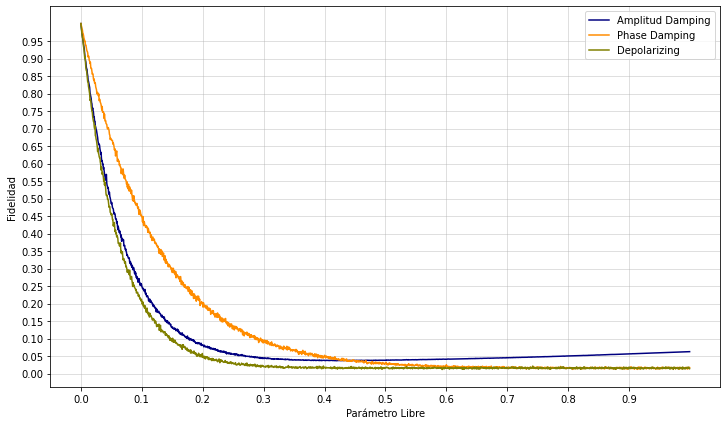

In [32]:
mpl.rcParams["figure.figsize"] = (12,7)
plt.plot(p_i, f_amp_sweep, color='navy', label='Amplitud Damping')
plt.plot(p_i, f_phs_sweep, color='darkorange', label='Phase Damping')
plt.plot(p_i, f_dprz_sweep, color='olive', label='Depolarizing')
plt.xlabel("Parámetro Libre")
plt.ylabel("Fidelidad")
plt.legend(loc='upper right');
plt.xticks(np.arange(0, 1, step=0.1))
plt.yticks(np.arange(0, 1, step=0.05))
plt.grid(alpha=0.2)
plt.grid(alpha=0.5)
plt.show()